# Construct Cancer-type Specific Container
In this notebook, I'd like to explore if it is possible to train a GCN on multi-omics data from a specific cancer type. This can be done in two ways, either patient-specific or averaged.
In the patient-specific way, each column of the feature matrix consists of 3 values per patient for expression, methylation and mutation scores. Maybe its possible to extend the graph convolutions to 3D.
In the other setting, we have three values per gene only, corresponding to the average mutation frequency, average differential DNA methlyation at promotors and average log2 fold change gene expression.

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import h5py
import matplotlib_venn

import os, sys
sys.path.append(os.path.abspath('../../GCN'))
import gcnIO

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Times New Roman')
%matplotlib inline

## Parameters

* `patient_specific`: Whether or not to output a 3D feature tensor with genes in the rows and columns corresponding to the patients and the third dimension corresponding to the 3 values for mutations, methylation and expression similar to channels in a image setting or whether to  only have 3 values per gene.
* `cancer_type`: The cancer type in question denoted by the TCGA study names
* `mutation_only`: If true, only use the mutation data, otherwise use all data
* `reference_container`: Which multi-omics reference container to use

In [2]:
patient_specific = True
cancer_type = 'BRCA'
mutation_only = False
reference_container = '../../data/pancancer/all_omics_final_CPDB/CPDB_multiomics.h5'
network_name = 'CPDB'

### Functions

In [3]:
submitter_project_mapping = pd.read_json('../../data/pancancer/TCGA/mutation/download_new/cases_all_cancers.2018-11-26.json')
submitter_project_mapping.head()
submitter_project_mapping['Cancer_Type'] = [dict(i)['project_id'] for i in submitter_project_mapping.project]
submitter_project_mapping = submitter_project_mapping[['submitter_id', 'Cancer_Type']].set_index('submitter_id')
submitter_project_mapping['Cancer_Type'] = [i[1] for i in submitter_project_mapping.Cancer_Type.str.split('-')]
trim_to_submitter = lambda x: '-'.join(str(x).split('-')[:3]) # TCGA barcode until patient

def write_hdf5_container(fname, A, F, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, feature_names, features_raw):
    f = h5py.File(fname, 'w')
    string_dt = h5py.special_dtype(vlen=str)
    f.create_dataset('network', data=A, shape=A.shape)
    f.create_dataset('features', data=F, shape=F.shape)
    f.create_dataset('gene_names', data=node_names, dtype=string_dt)
    f.create_dataset('y_train', data=y_train, shape=y_train.shape)
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)
    f.create_dataset('y_test', data=y_test, shape=y_test.shape)
    f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
    f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
    f.create_dataset('feature_names', data=np.array(feature_names, dtype=object), dtype=string_dt)
    f.create_dataset('features_raw', data=features_raw, shape=features_raw.shape)
    f.close()

    print ("Container written to {}".format(fname))

### Get Multi-Omics Data
Let's start by reading the mutation frequencies (CNA + SNV) for patients.

In [4]:
mutfreqs_patients = pd.read_hdf('../../data/pancancer/TCGA/mutation/mutation_frequencies_lengthnormalized.h5', 'snv_cna_sample_matrix').T
mutfreqs_patients.index = mutfreqs_patients.index.map(trim_to_submitter)
mutfreqs_patients = mutfreqs_patients.join(submitter_project_mapping)
mutation_features = mutfreqs_patients[mutfreqs_patients.Cancer_Type == cancer_type].T.drop('Cancer_Type', axis=0)

In [5]:
meth_samples = pd.read_hdf('../../data/pancancer/TCGA/methylation/sample_matrix_foldchanges.h5', 'methylation_sample_matrix').T
meth_samples['Cancer_Type'] = [i[1] for i in meth_samples.index.str.split('|')]
meth_features = meth_samples[meth_samples.Cancer_Type.str.upper() == cancer_type].T.drop('Cancer_Type', axis=0)
meth_features.columns = [i.split('|')[0].strip() for i in meth_features.columns] # remove everything but the TCGA barcode
meth_features.columns = meth_features.columns.map(trim_to_submitter) # remove parts of barcode that no longer describe the patient (submitter)

In [6]:
ge_samples = pd.read_hdf('../../data/pancancer/TCGA/expression/sample_matrix_fc_gtex.h5').T
ge_samples.index = ge_samples.index.map(trim_to_submitter)
ge_samples = ge_samples.join(submitter_project_mapping)
expr_features = ge_samples[ge_samples.Cancer_Type == cancer_type].T.drop('Cancer_Type', axis=0)

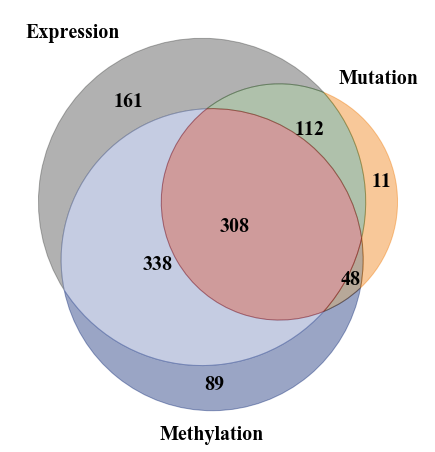

In [7]:
fig = plt.figure(figsize=(14, 8))
v = matplotlib_venn.venn3([set(expr_features.columns), set(mutation_features.columns), set(meth_features.columns)],
                          set_labels=["Expression", "Mutation", "Methylation"])
if not v.get_patch_by_id('10') is None:
    v.get_patch_by_id('10').set_color('#3d3e3d')
    v.get_label_by_id('10').set_fontsize(20)
if not v.get_patch_by_id('11') is None:
    v.get_patch_by_id('11').set_color('#37652d')
    v.get_label_by_id('11').set_fontsize(20)
v.get_patch_by_id('011').set_color('#4d2600')
v.get_label_by_id('A').set_fontsize(20)
v.get_label_by_id('B').set_fontsize(20)
v.get_label_by_id('C').set_fontsize(20)
if not v.get_patch_by_id('01') is None:
    v.get_patch_by_id('01').set_color('#ee7600')
    v.get_label_by_id('01').set_fontsize(20)
if not v.get_patch_by_id('111') is None and not v.get_patch_by_id('101') is None:
    v.get_label_by_id('111').set_fontsize(20)
    v.get_label_by_id('101').set_fontsize(20)
    v.get_patch_by_id('111').set_color('#890707')
    v.get_patch_by_id('101').set_color('#6E80B7')
if not v.get_patch_by_id('011') is None:
    v.get_label_by_id('011').set_fontsize(20)
if not v.get_patch_by_id('001') is None:
    v.get_patch_by_id('001').set_color('#031F6F')
    v.get_label_by_id('001').set_fontsize(20)

In [8]:
common_samples = set(expr_features.columns).intersection(mutation_features.columns).intersection(meth_features.columns)

### Adjust to PPI Nodes & Compute 3D Feature Tensor

In [10]:
data = gcnIO.load_hdf_data(reference_container)
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feature_names = data

In [11]:
scaler = preprocessing.MinMaxScaler()
nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('Name')

all_omics_normed = []
all_omics_raw = []
for feat in [mutation_features, meth_features, expr_features]:
    feat_avg_samples = feat.astype(np.float32).groupby(level=0, axis=1).mean() # average same patient's samples
    feat_ppiindex = feat_avg_samples.reindex(nodes.index, fill_value=0)
    feat_common = feat_ppiindex[common_samples]
    feat_normed = scaler.fit_transform(feat_common)
    all_omics_normed.append(feat_normed)
    all_omics_raw.append(feat_common.values)
    print (feat_normed.shape, feat_common.shape)

/home/sasse/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(13627, 308) (13627, 308)


/home/sasse/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(13627, 308) (13627, 308)
(13627, 308) (13627, 308)


/home/sasse/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [12]:
multiomics_features_3d = np.array(all_omics_normed)
multiomics_features_3d = multiomics_features_3d.reshape(multiomics_features_3d.shape[1], multiomics_features_3d.shape[2], 3)
multiomics_features_3d_raw = np.array(all_omics_raw)
multiomics_features_3d_raw = multiomics_features_3d_raw.reshape(multiomics_features_3d_raw.shape[1], multiomics_features_3d_raw.shape[2], 3)

### Construct Container with Cancertype-Specific Features

In [13]:
fname = '../../data/cancer_specific/{}_{}_{}.h5'.format(cancer_type, 'patients' if patient_specific else 'avg', 'mut' if mutation_only else 'all')

if mutation_only:
    final_features_normed = all_omics_normed[0]
    final_features_raw = all_omics_raw[0]
else:
    final_features_normed = multiomics_features_3d
    final_features_raw = multiomics_features_3d_raw

write_hdf5_container(fname,
                     A=adj,
                     F=final_features_normed,
                     node_names=node_names,
                     y_train=y_train, y_val=y_val, y_test=y_test,
                     train_mask=train_mask, val_mask=val_mask, test_mask=test_mask,
                     feature_names=feature_names,
                     features_raw=final_features_raw.astype(np.float32)
                    )  

Container written to ../../data/cancer_specific/BRCA_patients_all.h5
